----
# Comparing RS to established measures








In [3]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import time
import matplotlib.pyplot as plt
import PIL
from numpy import log10
import random
from math import factorial
import warnings
import pandas as pd
import re
import os
import math
from collections import Counter

from scipy.stats import linregress, gaussian_kde, skew
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
from scipy import stats

from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm


warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


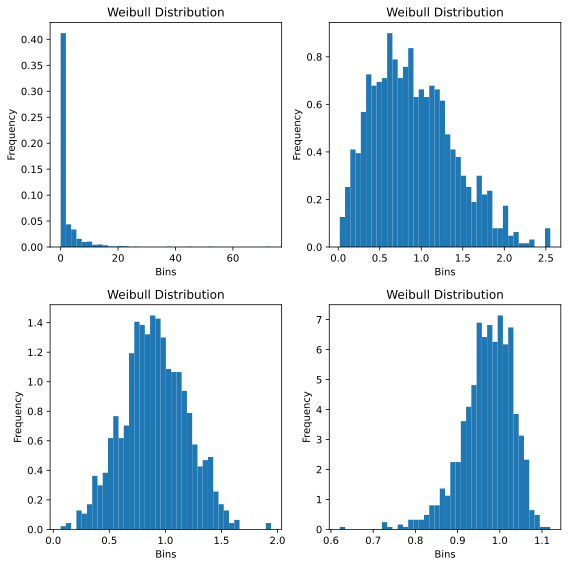

In [2]:
np.random.seed(0)

# Given parameters
n_obs = 1000
n_bins = 40

# Plotting histograms
plt.figure(figsize=(8, 8))

# Weibull parameters
weibull_shape = 0.5
# Generating data for different distributions
data_weibull = np.random.weibull(weibull_shape, n_obs)
# Calculating histogram
hist_vals_weibull, bins_weibull = np.histogram(data_weibull, bins=n_bins, density=True)

plt.subplot(2, 2, 1)
plt.bar(bins_weibull[:-1], hist_vals_weibull, width=(bins_weibull[1]-bins_weibull[0]), align='edge')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Weibull Distribution')



# Weibull parameters
weibull_shape = 2
# Generating data for different distributions
data_weibull = np.random.weibull(weibull_shape, n_obs)
# Calculating histogram
hist_vals_weibull, bins_weibull = np.histogram(data_weibull, bins=n_bins, density=True)

plt.subplot(2, 2, 2)
plt.bar(bins_weibull[:-1], hist_vals_weibull, width=(bins_weibull[1]-bins_weibull[0]), align='edge')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Weibull Distribution')


# Weibull parameters
weibull_shape = 3.5
# Generating data for different distributions
data_weibull = np.random.weibull(weibull_shape, n_obs)
# Calculating histogram
hist_vals_weibull, bins_weibull = np.histogram(data_weibull, bins=n_bins, density=True)

plt.subplot(2, 2, 3)
plt.bar(bins_weibull[:-1], hist_vals_weibull, width=(bins_weibull[1]-bins_weibull[0]), align='edge')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Weibull Distribution')


# Weibull parameters
weibull_shape = 20
# Generating data for different distributions
data_weibull = np.random.weibull(weibull_shape, n_obs)
# Calculating histogram
hist_vals_weibull, bins_weibull = np.histogram(data_weibull, bins=n_bins, density=True)

plt.subplot(2, 2, 4)
plt.bar(bins_weibull[:-1], hist_vals_weibull, width=(bins_weibull[1]-bins_weibull[0]), align='edge')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Weibull Distribution')

plt.tight_layout()
plt.show()


In [4]:

def histogram_intersection(p, q):
    
    # Calculate histogram intersection
    
    # q is the reference distribution
    # p is the query distribution
    
    minima = np.minimum(p, q)
    hi = np.true_divide(np.sum(minima), np.sum(p))
    
    if hi > 1 or hi < 0:
        print('Error, HI =', hi)
        print(p)
        print(q)
        return
    return hi


def chi_square_distance(p, q):
    
    # Calculate chi-square distance
    
    # q is the reference distribution
    # p is the query distribution
    
    # The following uses 'add one smoothing'
    p = np.array(p, dtype=float) + 1
    q = np.array(q, dtype=float) + 1
    p /= p.sum()
    q /= q.sum()

    return np.sum(((p - q)**2 / (p + q))) / 2


def kl_divergence(p, q):
    
    # Calculate Kullback-Leibler Divergence
    
    # q is the reference distribution
    # p is the query distribution
    
    # Ensure both lists are numpy arrays with dtype=float
    
    # The following uses 'add one smoothing'
    p = np.array(p, dtype=float) + 1
    q = np.array(q, dtype=float) + 1
    p /= p.sum()
    q /= q.sum()
    
    kl_div = np.sum(p * np.log(p / q))
    return kl_div


def earth_movers_distance(p, q):
    
    # Calculate Earth Mover's Distance
    
    # q is the reference distribution
    # p is the query distribution
    
    # Ensure both lists are numpy arrays with dtype=float
    p = np.array(p, dtype=float)
    q = np.array(q, dtype=float)

    # Normalize the distributions to ensure they sum to 1
    p /= p.sum()
    q /= q.sum()

    # Calculate cumulative distributions
    P = np.cumsum(p)
    Q = np.cumsum(q)

    # Calculate the cost matrix
    C = np.abs(np.subtract.outer(P, Q))

    # Solve the linear sum assignment problem
    row_ind, col_ind = linear_sum_assignment(C)

    # Calculate the Earth Mover's Distance
    emd = C[row_ind, col_ind].sum()

    return emd


def kolmogorov_smirnov_distance(p, q):
    
    # Calculate KS distance
    
    # q is the reference distribution
    # p is the query distribution
    
    # Ensure both lists are numpy arrays with dtype=float
    p = np.array(p, dtype=float)
    q = np.array(q, dtype=float)

    # Normalize the distributions to ensure they sum to 1
    p /= p.sum()
    q /= q.sum()

    # Calculate cumulative distributions
    P = np.cumsum(p)
    Q = np.cumsum(q)

    # Calculate the KS distance
    ks_distance = np.max(np.abs(P - Q))

    return ks_distance


def rank_probability_score(p, q):
    
    # Calculate the ranked probability score
    
    # q is the reference distribution
    # p is the query distribution
    
    # Ensure both lists are numpy arrays with dtype=float
    p = np.array(p, dtype=float)
    q = np.array(q, dtype=float)

    # Normalize the distributions to ensure they sum to 1
    p /= p.sum()
    q /= q.sum()

    # Calculate cumulative distributions
    P = np.cumsum(p)
    Q = np.cumsum(q)

    # Calculate Rank Probability Score
    rps = np.sum((P - Q)**2)

    return rps


def RDS(p, q):
    
    # Calculate Relative distribution shift
    
    # q is the reference distribution
    # p is the query distribution
    p_bins = len(p)
    p_obs = sum(p)
    
    q_bins = len(q)
    q_obs = sum(q)
    
    z_p = (p_bins + 1)/p_bins
    p = [sum(p[:ii+1])**(z_p) for ii in range(len(p))]
    Sp = np.sum(np.array(p)/(p_obs**z_p)) - 1
    Sp = Sp/(p_bins - 1)
    
    z_q = (q_bins + 1)/q_bins
    q = [sum(q[:ii+1])**(z_q) for ii in range(len(q))]
    Sq = np.sum(np.array(q)/(q_obs**z_q)) - 1
    Sq = Sq/(q_bins - 1)
    
    return Sq - Sp
    
    
def DS(p):
    p_bins = len(p)
    p_obs = sum(p)
    
    z_p = (p_bins + 1)/p_bins
    p = [sum(p[:ii+1])**(z_p) for ii in range(len(p))]
    Sp = np.sum(np.array(p)/(p_obs**z_p)) - 1
    ds = Sp/(p_bins - 1)
    return ds


In [4]:
def plot_colored_grid(x_values, y_values, color_values):
    
    # Function to create a colored grid with text annotations
    colors = np.zeros((4, 4), dtype=float)  # Initialize a 4x4 grid with zeros
    
    # Map x_values to grid coordinates
    x_mapping = {x: i+1 for i, x in enumerate(sorted(set(x_values)))}
    
    # Assign color values to grid coordinates
    for x, y, color in zip(x_values, y_values, color_values):
        x_grid = x_mapping[x]
        y_grid = y - min(y_values)  # Adjust y-values to start from 0
        colors[y_grid, x_grid - 1] = color  

    # Plot the colored grid
    plt.imshow(colors, interpolation='nearest', cmap='gray_r', origin='lower', vmin=0, vmax=1)

    # Add color bar
    #plt.colorbar(label='Color Values', ticks=np.linspace(0, 1, 5))

    # Add color value annotations inside each grid square
    for i in range(4):
        for j in range(4):
            # Determine font color based on color value
            font_color = 'white' if colors[i, j] >= 0.35 else 'black'
            plt.text(j, i, f'{colors[i, j]:.2f}', ha='center', va='center', color=font_color)

    # Add gridlines for clarity
    # plt.grid(True, which='both', color='black', linewidth=1.5)

    # Hide ticks
    plt.xticks([])
    plt.yticks([])

    # Show plot
    plt.show()

In [5]:
def generate_distributions(N, n, k, model, param):
    dists = []
    while len(dists) < N:
        
        if model == 'Poisson':
            data = np.random.poisson(param, n)
        
        elif model == 'Gaussian':
            data = np.random.normal(0, param, n)
        
        elif model == 'Negative binomial':
            data = np.random.negative_binomial(1, param, n)
        
        elif model == 'Lognormal':
            data = np.random.lognormal(0, param, n)
        
        elif model == 'Weibull':
            data = np.random.weibull(param, n)
        
        else:
            raise ValueError("Unsupported model type")

        hist_vals, bins = np.histogram(data, bins=k, density=False)
        dists.append(hist_vals.tolist())

    return dists


def get_r2(measure_vals, RDS_vals):
    xv = []
    yv = []
    for i, val in enumerate(measure_vals):
        if val > 0 and val < 10**10:
            xv.append(val)
            yv.append(RDS_vals[i])

    slope, intercept, r_val, p_val, std_err = linregress(xv, np.abs(yv))
    return round(r_val**2, 2)
    

In [6]:
rds_r2s = []
csd_r2s = []
ksd_r2s = []
hni_r2s = []
kld_r2s = []
emd_r2s = []
rps_r2s = []

rds_vals1 = []
csd_vals1 = []
ksd_vals1 = []
hni_vals1 = []
kld_vals1 = []
emd_vals1 = []
rps_vals1 = []

N = 10**5
n_obs = 100

n_bins_ls = [5, 10, 20, 40,
             5, 10, 20, 40,
             5, 10, 20, 40,
             5, 10, 20, 40,
            ]

param_values = [0.5, 0.5, 0.5, 0.5,
                1, 1, 1, 1,
                3.5, 3.5, 3.5, 3.5,
                20, 20, 20, 20,
               ]

for i, n_bins in enumerate(n_bins_ls):        
    
    rds_vals2 = []
    csd_vals2 = []
    ksd_vals2 = []
    hni_vals2 = []
    kld_vals2 = []
    emd_vals2 = []
    rps_vals2 = []
        
    shape = param_values[i]
    print(shape)
        
    num = 0
    while num < N:
        data = np.random.weibull(shape, n_obs)
        d1, bins = np.histogram(data, bins=n_bins, density=False)
        data = np.random.weibull(shape, n_obs)
        d2, bins = np.histogram(data, bins=n_bins, density=False)
            
        # Relative distributional shift
        j = RDS(d1, d2)
        rds_vals2.append(j)

        # KS distance
        j = kolmogorov_smirnov_distance(d1, d2)
        ksd_vals2.append(j)

        # Histogram intersection
        j = histogram_intersection(d1, d2)
        hni_vals2.append(1-j)

        # chi-square distance
        j = chi_square_distance(d1, d2)
        csd_vals2.append(np.sqrt(j))

        # KL divergence
        j = kl_divergence(d1, d2)
        kld_vals2.append(np.sqrt(j))

        # Rank probability score
        j = rank_probability_score(d1, d2)
        rps_vals2.append(np.sqrt(j))

        # Earth movers distance
        j = earth_movers_distance(d1, d2)
        emd_vals2.append(j)

        num += 1

        
    if shape == 1 and n_bins == 40:
        rds_vals1 = list(rds_vals2)
        csd_vals1 = list(csd_vals2)
        ksd_vals1 = list(ksd_vals2)
        hni_vals1 = list(hni_vals2)
        kld_vals1 = list(kld_vals2)
        emd_vals1 = list(emd_vals2)
        rps_vals1 = list(rps_vals2)
        
        
    r2 = get_r2(csd_vals2, rds_vals2)
    csd_r2s.append(r2)
    
    r2 = get_r2(ksd_vals2, rds_vals2)
    ksd_r2s.append(r2)
    
    r2 = get_r2(hni_vals2, rds_vals2)
    hni_r2s.append(r2)
    
    r2 = get_r2(kld_vals2, rds_vals2)
    kld_r2s.append(r2)
    
    r2 = get_r2(emd_vals2, rds_vals2)
    emd_r2s.append(r2)
    
    r2 = get_r2(rps_vals2, rds_vals2)
    rps_r2s.append(r2)

R2s = [emd_r2s, rps_r2s, ksd_r2s, kld_r2s, hni_r2s, csd_r2s]


0.5
0.5
0.5
0.5
1
1
1
1
3.5
3.5
3.5
3.5
20
20
20
20


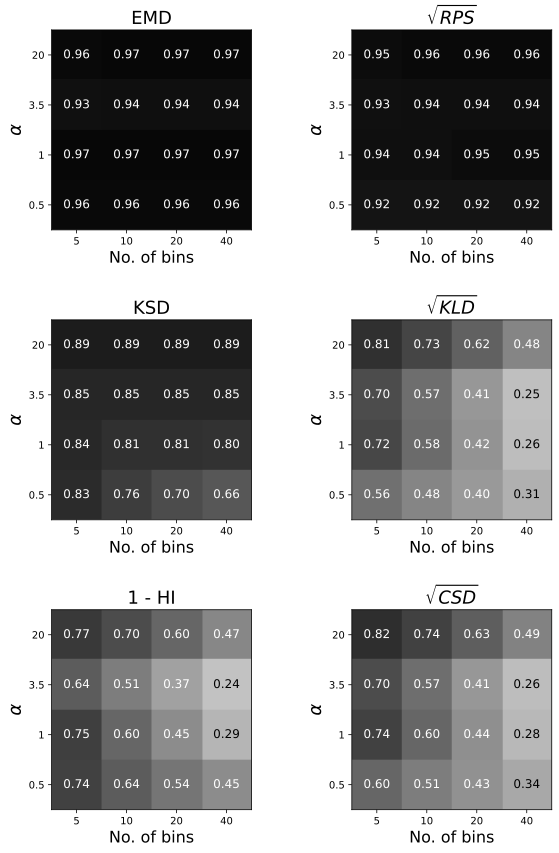

In [7]:

def plot_colored_grid(x_values, y_values, color_values, ax):
    # Initialize a 4x4 grid with zeros
    colors = np.zeros((4, 4), dtype=float)
    
    # Map x_values to grid coordinates
    x_mapping = {x: i+1 for i, x in enumerate(sorted(set(x_values)))}
    
    # Map y_values to grid coordinates
    y_mapping = {y: i+1 for i, y in enumerate(sorted(set(y_values)))}

    # Assign color values to grid coordinates
    for x, y, color in zip(x_values, y_values, color_values):
        x_grid = x_mapping[x]
        y_grid = y_mapping[y]
        colors[y_grid - 1, x_grid - 1] = color  

    # Plot the colored grid
    ax.imshow(colors, interpolation='nearest', cmap='gray_r', origin='lower', vmin=0, vmax=1)

    # Add color value annotations inside each grid square
    for i in range(4):
        for j in range(4):
            # Determine font color based on color value
            font_color = 'white' if colors[i, j] >= 0.35 else 'black'
            ax.text(j, i, f'{colors[i, j]:.2f}', 
                    ha='center', 
                    va='center', 
                    fontsize=12,
                    color=font_color)

    
    xticks = sorted(list(set(x_values)))
    yticks = sorted(list(set(y_values)))
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.arange(len(yticks)))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('No. of bins', fontsize=16)
    ax.set_ylabel(r'$\alpha$', fontsize=18)
    
    

# Function to create a 3x2 figure with subplots for each measure
def create_figure(n_bins_ls, param_values, R2s):
    measures = ['EMD', r"$\sqrt{RPS}$", 'KSD', r"$\sqrt{KLD}$", '1 - HI', r"$\sqrt{CSD}$"]
    fig, axs = plt.subplots(3, 2, figsize=(8, 12))

    for i, measure in enumerate(measures):
        row = i // 2
        col = i % 2

        ax = axs[row, col]

        # Generate x_values, y_values, and color_values for the subplot
        x_values = n_bins_ls
        y_values = param_values
        color_values = R2s[i]

        # Plot colored grid for the measure subplot
        ax.set_title(measure, fontsize=18)
        plot_colored_grid(x_values, y_values, color_values, ax)

    plt.tight_layout()
    fig.patch.set_facecolor('white')
    plt.subplots_adjust(hspace=0.45, wspace=0.4)
    plt.savefig('Final_Figs/manuscript/Fig5.jpg', bbox_inches='tight', format='jpg', dpi=600)
    plt.savefig('Final_Figs/manuscript/Fig5.pdf', bbox_inches='tight', format='pdf', dpi=600)
    plt.show()

# Call the function to create the figure
create_figure(n_bins_ls, param_values, R2s)


In [8]:
def count_pts_within_radius(x, y, radius, scale=0):
    """Count the number of points within a fixed radius in 2D space"""
    
    raw_data = np.array([x, y])
    x = np.array(x)
    y = np.array(y)
    raw_data = raw_data.transpose()
    
    # Get unique data points by adding each pair of points to a set
    unique_points = set()
    for xval, yval in raw_data:
        unique_points.add((xval, yval))
    
    count_data = []
    for a, b in unique_points:
        if scale == 'sqrt':
            num_neighbors = len(x[((sqrt(x) - sqrt(a)) ** 2 +
                                   (sqrt(y) - sqrt(b)) ** 2) <= sqrt(radius) ** 2])
        else:        
            num_neighbors = len(x[((x - a) ** 2 + (y - b) ** 2) <= radius ** 2])
        count_data.append((a, b, num_neighbors))
    return count_data



def plot_color_by_pt_dens(x, y, radius, loglog=0, scale=0, plot_obj=None, point_size=10):
    
    """Plot bivariate relationships with large n using color for point density

    Inputs:
    x & y -- variables to be plotted
    radius -- the linear distance within which to count points as neighbors
    scale -- a flag to indicate the use of a scale plot (scale = 1)

    The color of each point in the plot is determined by the logarithm (base 10)
    of the number of points that occur with a given radius of the focal point,
    with hotter colors indicating more points. The number of neighboring points
    is determined in linear space regardless of whether a scale plot is
    presented.
    """
    
    plot_data = count_pts_within_radius(x, y, radius, scale)
    sorted_plot_data = np.array(sorted(plot_data, key=lambda point: point[2]))

    if plot_obj == None:
        plot_obj = plt.axes()
        
    plot_obj.scatter(sorted_plot_data[:, 0],
            sorted_plot_data[:, 1],
            facecolors='none',
            s = point_size, 
            edgecolors='0.1', 
            linewidths=1., 
            #cmap='Greys'
            )
    
    # plot points
    c = np.array(sorted_plot_data[:, 2])**0.25
    c = np.max(c) - c
    plot_obj.scatter(sorted_plot_data[:, 0],
                    sorted_plot_data[:, 1],
                    c = c,
                    s = point_size, 
                    edgecolors='k', 
                    linewidths=0.0, 
                    cmap='Greys_r',
                    #alpha = 0.5,
                    )
        
    return plot_obj

In [11]:

X_lists = [ksd_vals1, 
           emd_vals1, 
           rps_vals1,
           csd_vals1, 
           hni_vals1, 
           kld_vals1,
          ]

x_labs = ['KSD',
          'EMD',
          r"$\sqrt{RPS}$",
          r"$\sqrt{CSD}$",
          '1 - HI',
          r"$\sqrt{KLD}$",
          ]

fig = plt.figure(figsize=(11, 11))

text_x_vals = [0.038, 0.25, 0.05, 
               0.12, 0.095, 0.18]

for i, x_ls in enumerate(X_lists):
    
    xv = []
    yv = []
    ct = 0
    for ii, val in enumerate(x_ls):
        
        if val > 0 and val < 10**10:
            xv.append(val)
            yv.append(rds_vals1[ii])
    
    if len(xv) < 10:
        continue
        
    plot_color_by_pt_dens(xv, yv, radius=0.05, loglog=0, plot_obj=plt.subplot(3, 3, i+1), point_size=10)
    slope, intercept, r_val, p_val, std_err = linregress(xv, np.abs(yv))
    fitted_vals = slope * np.array(xv) + intercept
    s = r'$r^{2}$' + ' = ' + str(round(r_val**2, 2))
    
    plt.text(text_x_vals[i], 0.9*np.nanmax(yv), s, fontsize=12)
    plt.xlabel(x_labs[i], fontsize= 12)
    plt.ylabel('RDS', fontsize= 12)
    plt.tick_params(axis='both', labelsize=10)
    
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.4, wspace=0.5)
plt.savefig('Final_Figs/manuscript/Fig6.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig6.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.close()


## Check for symmetry

In [18]:
num = 0
N = 10**3
n_obs = 100
n_bins = 40

rds_sym = 'RDS is symmetrical'
emd_sym = 'EMD is symmetrical'
kld_sym = 'KLD is symmetrical'
ksd_sym = 'KSD is symmetrical'
csd_sym = 'CSD is symmetrical'
hni_sym = '1 - HI is symmetrical'
rps_sym = 'RPS is symmetrical'

while num < N:
    n_bins = np.random.randint(4, 40)
    n_obs = np.random.randint(50, 200)
    
    shape1 = np.random.uniform(0.5, 20)
    shape2 = np.random.uniform(0.5, 20)
    
    data = np.random.weibull(shape1, n_obs)
    d1, bins = np.histogram(data, bins=n_bins, density=False)
    
    data = np.random.weibull(shape2, n_obs)
    d2, bins = np.histogram(data, bins=n_bins, density=False)
            
    # Relative distributional shift
    rds1 = RDS(d1, d2)
    rds2 = RDS(d2, d1)
    if np.abs(rds1) != np.abs(rds2):
        rds_sym = 'RDS is not symmetrical'
    
    
    # KS distance
    j1 = kolmogorov_smirnov_distance(d1, d2)
    j2 = kolmogorov_smirnov_distance(d2, d1)
    if j1 != j2:
        ksd_sym = 'KSD is not symmetrical'
    
    # Histogram intersection
    j1 = histogram_intersection(d1, d2)
    j2 = histogram_intersection(d2, d1)
    if j1 != j2:
        hni_sym = '1 - HI is not symmetrical'
        
    # chi-square distance
    j1 = chi_square_distance(d1, d2)
    j2 = chi_square_distance(d2, d1)
    if j1 != j2:
        csd_sym = 'CSD is not symmetrical'
        
    # KL divergence
    j1 = kl_divergence(d1, d2)
    j2 = kl_divergence(d2, d1)
    if j1 != j2:
        kld_sym = 'KLD is not symmetrical'
        
    # Rank probability score
    j1 = rank_probability_score(d1, d2)
    j2 = rank_probability_score(d2, d1)
    if j1 != j2:
        rps_sym = 'RPS is not symmetrical'
        
    # Earth movers distance
    j1 = earth_movers_distance(d1, d2)
    j2 = earth_movers_distance(d2, d1)
    if round(j1, 6) != round(j2,6):
        emd_sym = 'EMD is not symmetrical'
        print(j1, j2)
        break
        
    num += 1
    
print(rds_sym)
print(rps_sym)
print(csd_sym)
print(ksd_sym)
print(emd_sym)
print(hni_sym)
print(kld_sym)


RDS is symmetrical
RPS is symmetrical
CSD is symmetrical
KSD is symmetrical
EMD is symmetrical
1 - HI is symmetrical
KLD is not symmetrical
